<a href="https://colab.research.google.com/github/osilian/ml4sc-project/blob/master/disc-benchmark-files/identification_NARX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Load required packages
import torch
from torch import nn
from matplotlib import pyplot as plt
plt.rcParams.update({'text.usetex': False})

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Create Datasets and apply Preprocessing

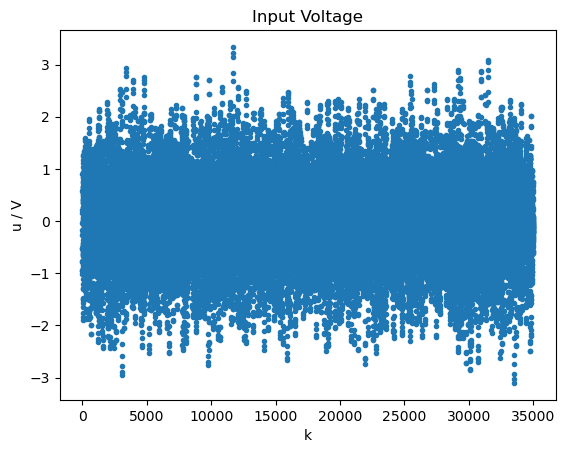

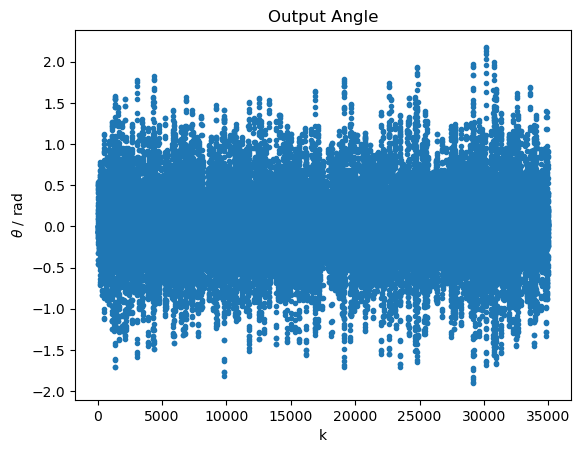

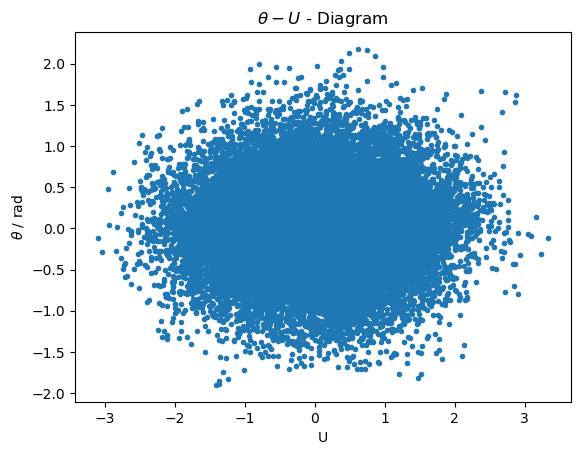

In [9]:
# Load Benchmark Data

out = np.load('training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

# Plot Data
plt.plot(u_train,'.')
plt.title('Input Voltage')
plt.xlabel('k')
plt.ylabel('u / V')
plt.show()

plt.plot(th_train,'.')
plt.title('Output Angle')
plt.xlabel('k')
plt.ylabel(r'$\theta$ / rad')
plt.show()

plt.plot(u_train,th_train,'.')
plt.title(r'$\theta - U$ - Diagram')
plt.xlabel('U')
plt.ylabel(r'$\theta$ / rad')
plt.show()


def create_IO_data(u,y,na,nb):
    X = []
    Y = []
    for k in range(max(na,nb), len(y)):
        X.append(np.concatenate([u[k-nb:k],y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)

def create_search_data(na, nb, uTrain=u_train, yTrain=th_train, testSize=0.2):
    # Create Time-Series Datasets
    Xdata, Ydata = create_IO_data(uTrain, yTrain, na, nb)

    # split into training in validation data
    from sklearn import model_selection
    Xtrain, Xval, Ytrain, Yval = model_selection.train_test_split(Xdata, Ydata, shuffle=True, test_size=testSize,random_state=42)

    Xtrain, Xval, Ytrain, Yval = [torch.as_tensor(x,dtype=torch.float32,device=device) for x in [Xtrain, Xval, Ytrain, Yval]] #convert it to torch arrays
    return Xtrain, Xval, Ytrain, Yval



### Create and Train NARX NN

In [3]:
class narxNetwork(nn.Module):
    def __init__(self, na, nb, n_hidden_nodes,activation=nn.Sigmoid):
        super(narxNetwork,self).__init__()
        seq = [nn.Linear(na+nb,n_hidden_nodes), activation()]
        seq.append(nn.Linear(n_hidden_nodes,1))

        self.narx_net = nn.Sequential(*seq)


    def forward(self,x): #a)
        #x = concatenated [upast and ypast] #a)
        y = self.narx_net(x)[:,0]
        return y #a)






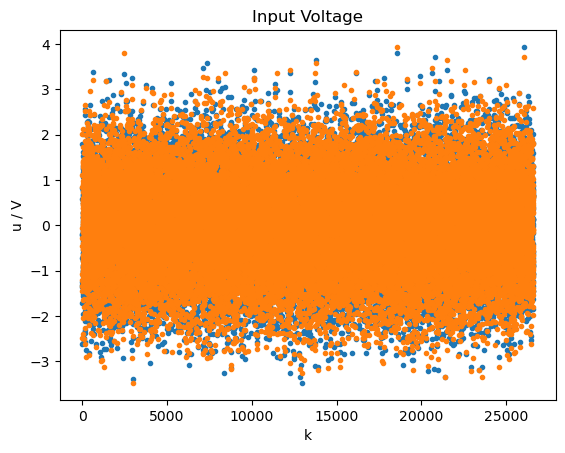

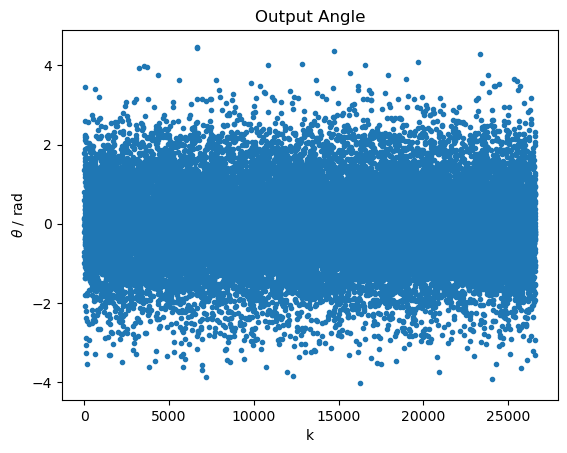

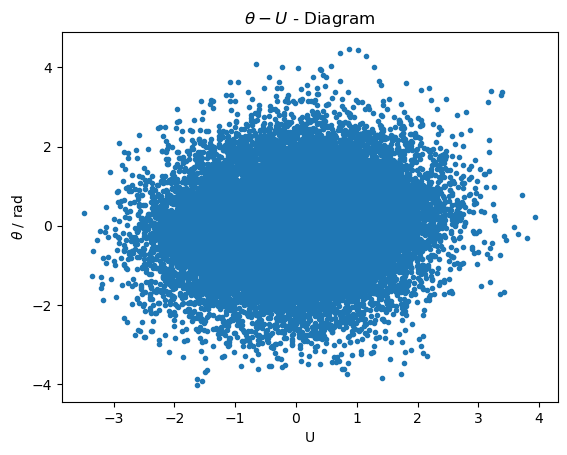

After Normalization - umean =-0.0005545066087506711, ustd =1.0
After Normalization - ymean - X =-0.0016754262614995241, ystd -X =0.9994484782218933
After Normalization - ymean - y =1.4344742060856674e-09, ystd -y =1.0


In [4]:
n_hidden_nodes = 64
na, nb = 7, 2
# test split off
testStartIndex = len(u_train)//20
u_train_small = u_train[:-(testStartIndex+1)]
y_train_small = th_train[:-(testStartIndex+1)]
Xtest, Ytest = create_IO_data(u_train[-testStartIndex:], th_train[-(testStartIndex):], na, nb)
Xtest, Ytest = [torch.as_tensor(x,dtype=torch.float32,device=device) for x in [Xtest, Ytest]] 

Xtrain, Xval, Ytrain, Yval = create_search_data(na, nb, uTrain=u_train_small, yTrain=y_train_small, testSize=0.2)
u_train_mean = torch.mean(Xtrain[:,:nb]).item()
u_train_std = torch.std(Xtrain[:,:nb]).item()
y_train_mean = torch.mean(Ytrain).item()
y_train_std = torch.std(Ytrain).item()
class dataNormalization():
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max

    def normalize(self, XData, YData):
        #Xnorm = 2 * (XData - self.x_min) / (self.x_max - self.x_min) - 1 # -1 and * 2 to always normalize into (-1,1) no matter what the smallest x_min is
        #Ynorm = 2 * (YData - self.y_min) / (self.y_max - self.y_min) - 1
        unorm = (XData[:,:nb]-u_train_mean)/u_train_std
        yPastNorm = (XData[:,nb:] - y_train_mean) / y_train_std
        Xnorm = torch.cat((unorm, yPastNorm), dim=1)
        Ynorm = (YData-y_train_mean)/y_train_std
        #Xnorm = XData
        #Ynorm = YData
        return Xnorm, Ynorm

    def denormalize(self, YData_norm):
        #YData = 0.5 * (YData_norm + 1) * (self.y_max - self.y_min) + self.y_min
        YData = YData_norm*y_train_std + y_train_mean
        #YData = YData_norm
        return YData
x_min = -3 #torch.min(torch.min(Xtrain)).item()
x_max = +3 #torch.max(torch.min(Xtrain)).item()
y_min = -2/3*np.pi  #torch.min(torch.min(Ytrain)).item()
y_max = +2/3*np.pi   #torch.max(torch.min(Ytrain)).item()
dataNorm = dataNormalization(x_min,x_max,y_min,y_max)

Xtrain_norm, Ytrain_norm = dataNorm.normalize(Xtrain, Ytrain)
Xval_norm, Yval_norm = dataNorm.normalize(XData=Xval, YData=Yval)

# Plot Data
plt.plot(Xtrain_norm[:,:nb].cpu(),'.')
plt.title('Input Voltage')
plt.xlabel('k')
plt.ylabel('u / V')
plt.show()

plt.plot(Ytrain_norm.cpu(),'.')
plt.title('Output Angle')
plt.xlabel('k')
plt.ylabel(r'$\theta$ / rad')
plt.show()

plt.plot(Xtrain_norm[:,nb-1].cpu(),Ytrain_norm.cpu(),'.')
plt.title(r'$\theta - U$ - Diagram')
plt.xlabel('U')
plt.ylabel(r'$\theta$ / rad')
plt.show()

print(f'After Normalization - umean ={torch.mean(Xtrain_norm[:,nb-1]).item()}, ustd ={torch.std(Xtrain_norm[:,:nb]).item()}')
print(f'After Normalization - ymean - X ={torch.mean(Xtrain_norm[:,nb:]).item()}, ystd -X ={torch.std(Xtrain_norm[:,nb:]).item()}')
print(f'After Normalization - ymean - y ={torch.mean(Ytrain_norm[:]).item()}, ystd -y ={torch.std(Ytrain_norm[:]).item()}')

In [ ]:
model = narxNetwork(na, nb, n_hidden_nodes,activation=nn.ReLU)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

epochs = 55*10**3
for epoch in range(epochs):
    Loss = torch.mean((model(Xtrain_norm)-Ytrain_norm)**2)
    optimizer.zero_grad()
    Loss.backward()
    optimizer.step()
    RMS_val = y_train_std * torch.mean((model(Xval_norm)-Yval_norm)**2).item()**0.5
    if epoch%1000==0:
        print(f'Epoch {epoch}, RMS Training: {y_train_std * Loss.item()}, RMS Val: {RMS_val}')


Epoch 0, RMS Training: 0.4641424529796403, RMS Val: 0.47064505095609593
Epoch 1000, RMS Training: 0.006113147860378032, RMS Val: 0.05428112870723166
Epoch 2000, RMS Training: 0.003307243821560002, RMS Val: 0.03985899211689749
Epoch 3000, RMS Training: 0.0015773666864629526, RMS Val: 0.027672724492537593


In [ ]:
# save / load trained model if desired
if False:
    torch.save(model.state_dict(),"NARX_XX.pt")
if True:
    model = narxNetwork(na, nb, n_hidden_nodes,activation=nn.ReLU)
    model.to(device)
    model.load_state_dict(torch.load("NARX.pt",map_location=torch.device(device)))

In [ ]:
# Grid search
def fit(net, X_data, Y_data, X_val, Y_val, lr, epochs=10*10**3):
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    best_state = None
    best_loss = float('inf')

    for epoch in range(1,epochs+1):
        loss = torch.mean((net(X_data)-Y_data)**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch%1000==0:
            loss_val = torch.mean((net(X_val)-Y_val)**2).item()**0.5
            if loss_val<best_loss:
                from copy import deepcopy
                best_state = deepcopy(net.state_dict())
                best_loss = loss_val
            print(f'epoch={epoch:5}, loss={loss.item()**0.5:.2f}')
    if best_state:
        net.load_state_dict(best_state)
    return net

import functools
@functools.lru_cache(maxsize=500, typed=False)
def test(X_train, Y_train, X_val, Y_val, na=2, nb=2, n_hidden_nodes=20, activation=nn.Tanh, lr=1e-3):
    net = narxNetwork(na, nb, n_hidden_nodes, activation)
    net = net.to(device)
    net = fit(net, X_train, Y_train, X_val, Y_val, lr)
    RMS = y_train_std * torch.mean((net(X_val)-Y_val)**2).item()**0.5
    return RMS


current_best = dict(na=5, nb=5, n_hidden_nodes=5, activation=nn.Sigmoid, lr=1e-3)
choices_dict = dict(na=[3,4,5,6,7,8], \
                nb=[1,2,3,4,5,6,7,8], \
                n_hidden_nodes=[16,32,64], \
                activation=[nn.ReLU, nn.Sigmoid, nn.Tanh], \
                lr = [1e-3]
                )
'''
choices_dict = dict(na=[3, 6, 9, 12, 15], \
                nb=[3, 6, 9, 12, 15], \
                n_hidden_nodes=[10, 15, 20, 30, 50, 100], \
                activation=[nn.Sigmoid, nn.Tanh, nn.ReLU], \
                lr = [1e-3, 1e-4]
                )
'''
import itertools
gridKeys = choices_dict.keys()
grid = list(itertools.product(*choices_dict.values()))

best_score = float('inf')
best_params = None
results = []
import copy
for params in grid:
    choice = dict(zip(gridKeys,params))
    print('optimizing...',choice)

    # create dataset
    Xtrain, Xval, Ytrain, Yval = create_search_data(choice['na'],choice['nb'])
    Xtrain_norm, Ytrain_norm = dataNorm.normalize(Xtrain, Ytrain)
    Xval_norm, Yval_norm = dataNorm.normalize(Xval,Yval)
    rmse = test(Xtrain_norm, Ytrain_norm, Xval_norm, Yval_norm,**choice)
    results.append((choice, rmse)) #add it to results

    if rmse < best_score:
        best_score = rmse
        best_params = choice



optimizing... {'na': 3, 'nb': 1, 'n_hidden_nodes': 16, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.001}
epoch= 1000, loss=0.06
epoch= 2000, loss=0.03
epoch= 3000, loss=0.03
epoch= 4000, loss=0.02
epoch= 5000, loss=0.02
epoch= 6000, loss=0.02
epoch= 7000, loss=0.02
epoch= 8000, loss=0.01
epoch= 9000, loss=0.01
epoch=10000, loss=0.01
optimizing... {'na': 3, 'nb': 1, 'n_hidden_nodes': 16, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>, 'lr': 0.001}
epoch= 1000, loss=0.24
epoch= 2000, loss=0.06
epoch= 3000, loss=0.05
epoch= 4000, loss=0.04
epoch= 5000, loss=0.03
epoch= 6000, loss=0.02
epoch= 7000, loss=0.02
epoch= 8000, loss=0.02
epoch= 9000, loss=0.02
epoch=10000, loss=0.02
optimizing... {'na': 3, 'nb': 1, 'n_hidden_nodes': 16, 'activation': <class 'torch.nn.modules.activation.Tanh'>, 'lr': 0.001}
epoch= 1000, loss=0.05
epoch= 2000, loss=0.03
epoch= 3000, loss=0.02
epoch= 4000, loss=0.02
epoch= 5000, loss=0.02
epoch= 6000, loss=0.02
epoch= 7000, loss=0.0

In [ ]:
# save grid search if desired
import pickle
with open("grid_search_narx_XX","wb") as f:
  pickle.dump(results,f)

#train model based on grid search
print(best_params)
model = narxNetwork(best_params['na'],best_params['nb'],best_params['n_hidden_nodes'],best_params['activation'])
#model = narxNetwork(best_params['na'],best_params['nb'],50,best_params['activation'])
model = model.to(device)
na, nb = best_params['na'], best_params['nb']

Xtrain, Xval, Ytrain, Yval = create_search_data(best_params['na'],best_params['nb'],testSize=0.3)
Xtrain_norm, Ytrain_norm = dataNorm.normalize(Xtrain, Ytrain)
Xval_norm, Yval_norm = dataNorm.normalize(Xval,Yval)

optimizer = torch.optim.Adam(model.parameters())
epochs = 20*10**3
for epoch in range(epochs):
    Loss = torch.mean((model(Xtrain_norm)-Ytrain_norm)**2)
    optimizer.zero_grad()
    Loss.backward()
    optimizer.step()
    if epoch%1000==0:
        print(epoch,y_train_std * Loss.item())

{'na': 8, 'nb': 5, 'n_hidden_nodes': 64, 'activation': <class 'torch.nn.modules.activation.Tanh'>, 'lr': 0.001}
0 0.4470053721526135
1000 0.001241031470599549
2000 0.00023934724032401503
3000 0.00012949551980304293
4000 7.303509588881246e-05
5000 4.701461456010957e-05
6000 3.675347710961445e-05
7000 3.0222272398409706e-05
8000 2.596317472519519e-05
9000 2.4227666359485965e-05
10000 3.101191301213514e-05
11000 2.2044403049687085e-05
12000 2.1316036258672236e-05
13000 2.1858631119343885e-05
14000 2.428052597893554e-05
15000 2.0073630211169067e-05
16000 2.5667576768792066e-05
17000 2.4044790464268885e-05
18000 2.06864085640628e-05
19000 1.979969494642921e-05


train prediction errors:
RMS: tensor(0.0029) radians
RMS: tensor(0.1641) degrees
NRMS: tensor(0.5962) %


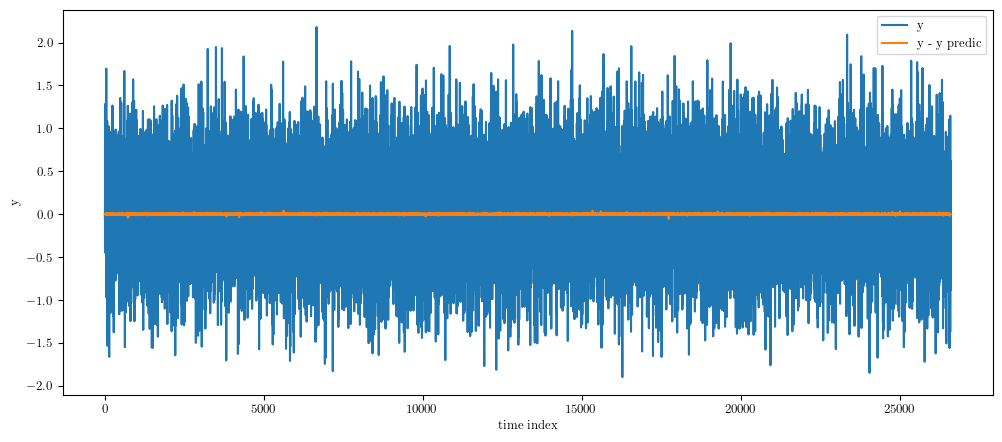

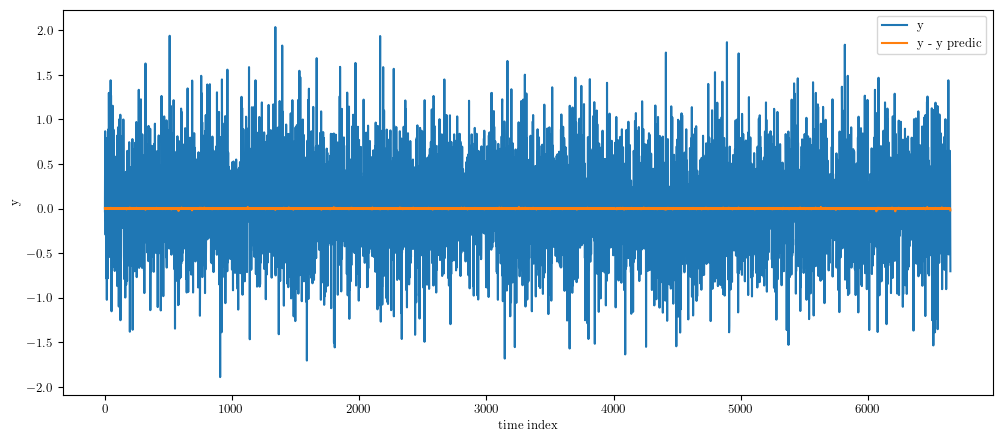

validation-set: prediction errors:
RMS: 0.0028881331916125134 radians
RMS: 0.1654778425510453 degrees
NRMS: tensor(0.6004) %


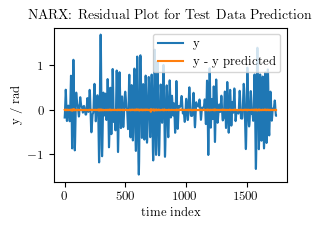

test-set: prediction errors:
RMS: 0.0029285760661260374 radians
RMS: 0.16779504857204744 degrees
NRMS: tensor(0.6386) %


In [ ]:
#residual calculations and plotting
with torch.no_grad():
    Ytrain_pred_norm = model(Xtrain_norm)
    Ytrain_pred = dataNorm.denormalize(YData_norm=Ytrain_pred_norm)
    Ytrain = Ytrain.to(device)
    print('train prediction errors:')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5,'radians')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/Ytrain.std()*100,'%')
    res = Ytrain_pred - Ytrain
    plt.figure(figsize=(12,5))
    plt.plot(Ytrain.cpu())
    plt.plot(res.cpu())
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])
    plt.show()

    Xval_norm, _ = dataNorm.normalize(XData=Xval, YData=Yval)
    Yval_pred_norm = model(Xval_norm)
    Yval_pred = dataNorm.denormalize(Yval_pred_norm)
    Yval = Yval.to(device)
    res = Yval_pred - Yval
    plt.figure(figsize=(12,5))
    plt.plot(Yval.cpu())
    plt.plot(res.cpu())
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])
    plt.show()
    print('validation-set: prediction errors:')
    print('RMS:', torch.mean((Yval_pred-Yval)**2).item()**0.5,'radians')
    print('RMS:', torch.mean((Yval_pred-Yval)**2).item()**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Yval_pred-Yval)**2).item()**0.5/Yval.std()*100,'%')

    # Test Set
    Xtest_norm, _ = dataNorm.normalize(XData=Xtest, YData=Ytest)
    Ytest_pred_norm = model(Xtest_norm)
    Ytest_pred = dataNorm.denormalize(Ytest_pred_norm)
    Ytest = Ytest.to(device)
    res = Ytest_pred - Ytest
    plt.figure(figsize=(3,2))
    plt.plot(Ytest.cpu())
    plt.plot(res.cpu())
    plt.title('NARX: Residual Plot for Test Data Prediction')
    plt.xlabel('time index'); plt.ylabel('y / rad'); plt.legend(['y', 'y - y predicted'])
    #plt.savefig("NARX_Test_Prediction.pdf",bbox_inches='tight')
    plt.show() #b)
    print('test-set: prediction errors:')
    print('RMS:', torch.mean((Ytest_pred-Ytest)**2).item()**0.5,'radians')
    print('RMS:', torch.mean((Ytest_pred-Ytest)**2).item()**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Ytest_pred-Ytest)**2).item()**0.5/Ytest.std()*100,'%')
    
    

trained simulation errors:
RMS: 0.020541205215380855 radians
RMS: 1.1769243649534382 degrees
NRMS: 4.285334012006435 %


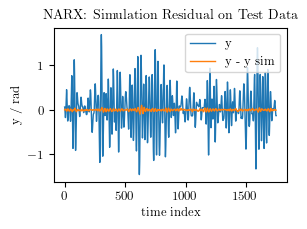

test simulation errors:
RMS: 0.013247905090441667 radians
RMS: 0.7590490490721867 degrees
NRMS: 2.7637958764655792 %


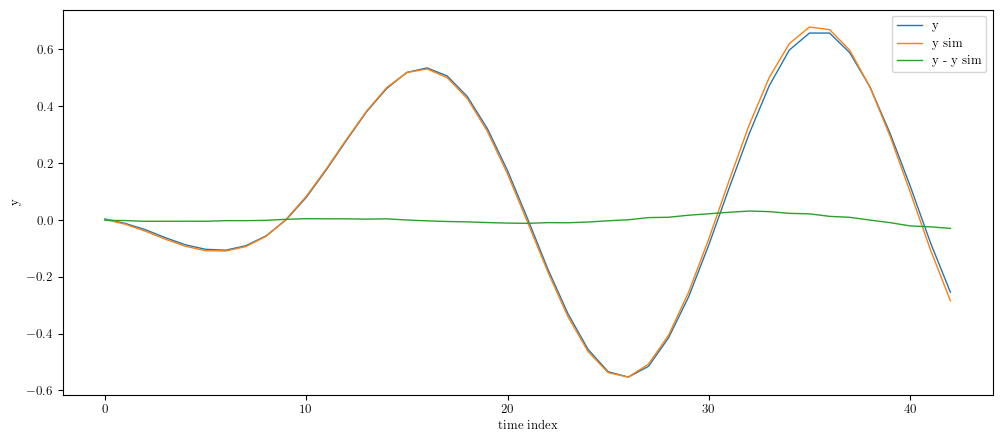

In [ ]:
# Set up simulation for identified net
# Simulation Test

out = np.load('training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

data = np.load('hidden-test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros

def simulation_IO_model(f, ulist, ylist, skip=50):
    upast = ulist[skip-nb:skip].tolist() #good initialization
    ypast = ylist[skip-na:skip].tolist()
    Y = ylist[:skip].tolist()
    for u in ulist[skip:]:
        x = np.concatenate([upast,ypast],axis=0)
        x = torch.as_tensor(x[None,:],dtype=torch.float32, device=device)
        x_norm,_ = dataNorm.normalize(x,x)
        ypred = f(x_norm)[0].cpu()
        ypred = dataNorm.denormalize(ypred.detach().numpy())
        Y.append(ypred)
        upast.append(u)
        upast.pop(0)
        ypast.append(ypred)
        ypast.pop(0)
    return np.array(Y)
skip = len(u_train) - testStartIndex
#skip = max(na,nb)
th_train_sim = simulation_IO_model(lambda x: model(x[None,:])[0], u_train, th_train, skip=skip)
print('trained simulation errors:')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5,'radians')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/th_train.std()*100,'%')
# Plotting
res = th_train_sim[skip:] - th_train[skip:]
plt.figure(figsize=(3,2))
plt.plot(th_train[skip:])
#plt.plot(th_train_sim[skip:])
plt.plot(res)
plt.xlabel('time index'); plt.ylabel('y / rad'); plt.legend(['y','y - y sim'])
#plt.xlabel('time index'); plt.ylabel('res / rad'); plt.legend(['y - y simulated'])
plt.title('NARX: Simulation Residual on Test Data')
#plt.savefig("NARX_Test_Simulation_error.pdf",bbox_inches='tight')
plt.show()

skip = max(na,nb)
th_test_sim = simulation_IO_model(lambda x: model(x[None,:])[0], u_test, th_test, skip=skip)
print('test simulation errors:')
print('RMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5,'radians')
print('RMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5/th_train.std()*100,'%')
# Plotting
res = th_test_sim[skip:50] - th_test[skip:50]
plt.figure(figsize=(12,5))
plt.plot(th_test[skip:50])
plt.plot(th_test_sim[skip:50])
plt.plot(res)
plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y sim','y - y sim'])
plt.show()

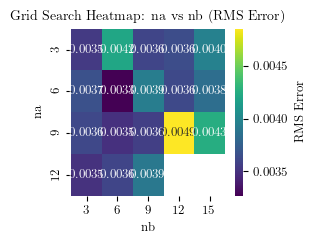

RuntimeError: latex was not able to process the following string:
b'Grid Search Heatmap: Activation Function vs # Hidden Nodes (RMS Error) (na=6, nb=3, lr=0.001)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp43lvqt_d 8a9b0d16bc625a0c39eba32da43bf837.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2025) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./8a9b0d16bc625a0c39eba32da43bf837.tex
LaTeX2e <2024-11-01> patch level 2
L3 programming layer <2025-01-18>
(c:/texlive/2025/texmf-dist/tex/latex/base/article.cls
Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
(c:/texlive/2025/texmf-dist/tex/latex/base/size10.clo))
(c:/texlive/2025/texmf-dist/tex/latex/type1cm/type1cm.sty)
(c:/texlive/2025/texmf-dist/tex/latex/cm-super/type1ec.sty
(c:/texlive/2025/texmf-dist/tex/latex/base/t1cmr.fd))
(c:/texlive/2025/texmf-dist/tex/latex/base/inputenc.sty)
(c:/texlive/2025/texmf-dist/tex/latex/geometry/geometry.sty
(c:/texlive/2025/texmf-dist/tex/latex/graphics/keyval.sty)
(c:/texlive/2025/texmf-dist/tex/generic/iftex/ifvtex.sty
(c:/texlive/2025/texmf-dist/tex/generic/iftex/iftex.sty)))
(c:/texlive/2025/texmf-dist/tex/latex/underscore/underscore.sty)
(c:/texlive/2025/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(c:/texlive/2025/texmf-dist/tex/latex/base/textcomp.sty)
(c:/texlive/2025/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 8a9b0d16bc625a0c39eba32da43bf837.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in horizontal mode.
l.29 ...d Search Heatmap: Activation Function vs #
                                                   Hidden Nodes (RMS Error) ...

No pages of output.
Transcript written on tmp43lvqt_d/8a9b0d16bc625a0c39eba32da43bf837.log.




<Figure size 300x250 with 2 Axes>

     na  nb  model_order  n_hidden_nodes activation       RMS
303   7   2            9              64       ReLU  0.002968
240   6   3            9              64       ReLU  0.003017
114   4   5            9              64       ReLU  0.003259
177   5   4            9              64       ReLU  0.003266
174   5   4            9              32       ReLU  0.003272


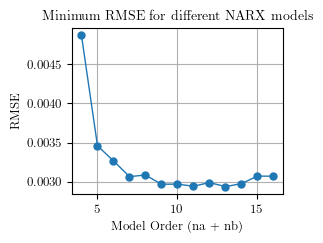

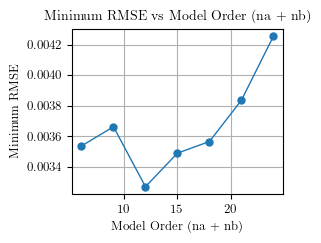

In [ ]:
# import saved grid search

import pickle

file_path = 'grid_search'

with open(file_path, 'rb') as f:
    results_grid = pickle.load(f)

# visualization
import matplotlib.pyplot as plt
import pandas as pd

params = {'text.usetex' : True,
            'font.size' : 9,
            'font.family' : 'lmodern',
            'axes.titlesize' : 10,
            'axes.labelsize' : 9,
            'figure.figsize' : (3.0,2.5),
            'lines.linewidth' : 1,
            'lines.markersize' : 5,
            'xtick.labelsize' : 9,
            'ytick.labelsize' : 9,
            }
plt.rcParams.update(params)


# finer grid search
file_path = 'grid_search_narx_final'

with open(file_path, 'rb') as f:
    results_grid_fine = pickle.load(f)


df = pd.DataFrame([
    {
        'na': params['na'],
        'nb': params['nb'],
        'model_order': params['na'] + params['nb'],
        'n_hidden_nodes': params['n_hidden_nodes'],
        'activation': str(params['activation']).split('.')[-1].split("'")[0],
        'RMS': rms
    }
    for params, rms in results_grid_fine
])
overview_order_9 = df[df['model_order']==9]

print(overview_order_9.sort_values(by='RMS').head())


df = pd.DataFrame([
    {
        'na': params['na'],
        'nb': params['nb'],
        'model_order': params['na'] + params['nb'],
        'RMS': rms
    }
    for params, rms in results_grid_fine
])

order_vs_min_rms = df.groupby('model_order')['RMS'].min().reset_index()

plt.figure()
plt.plot(order_vs_min_rms['model_order'], order_vs_min_rms['RMS'], marker='o', linestyle='-')
plt.title('Minimum RMSE for different NARX models')
plt.xlabel('Model Order (na + nb)')
plt.ylabel('RMSE')
plt.grid(True)
plt.tight_layout()
#plt.savefig('grid_search_nanb.pdf')
plt.show()

df = pd.DataFrame([
    {
        'na': params['na'],
        'nb': params['nb'],
        'model_order': params['na'] + params['nb'],
        'RMS': y_train_std * rms
    }
    for params, rms in results_grid
    if (params['na'] >= 3) and (params['n_hidden_nodes']==100)
])

order_vs_min_rms = df.groupby('model_order')['RMS'].min().reset_index()

plt.figure()
plt.plot(order_vs_min_rms['model_order'], order_vs_min_rms['RMS'], marker='o', linestyle='-')
plt.title('Minimum RMSE vs Model Order (na + nb)')
plt.xlabel('Model Order (na + nb)')
plt.ylabel('Minimum RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()